Eileanor LaRocco - Deep Learning

In [6]:
# Libraries
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# Load Train Data
train = pd.read_csv("train.csv",dtype = np.float32)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: float32(785)
memory usage: 125.8 MB


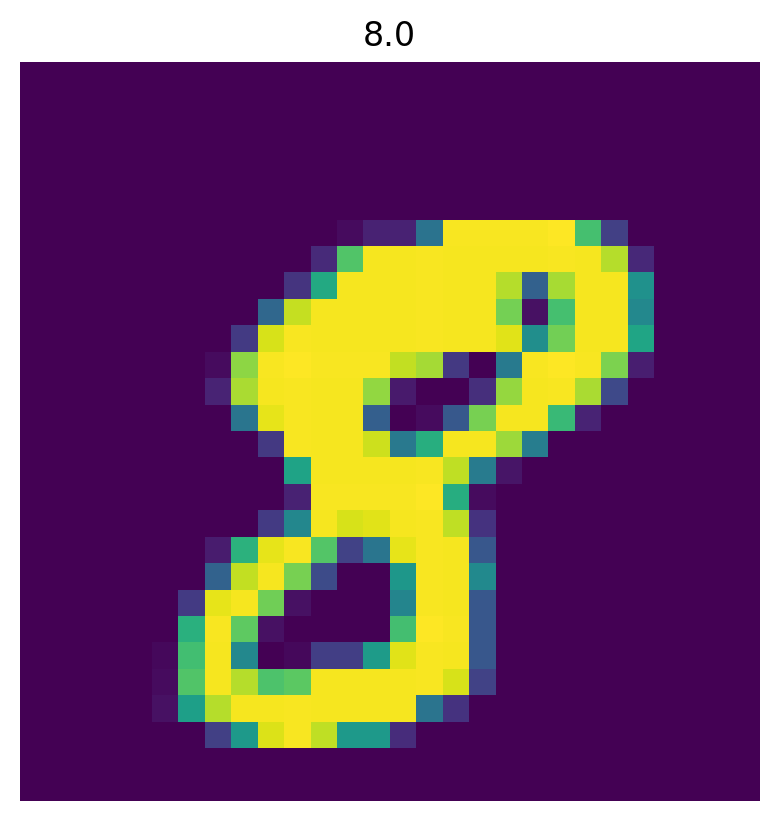

In [17]:
# Prepare Dataset

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

#split data into training and testing sets
features_train, features_test, target_train, target_test = train_test_split(features_numpy, targets_numpy, test_size=0.2, random_state=42)

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
features_train = torch.from_numpy(features_train)
target_train = torch.from_numpy(target_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
features_test = torch.from_numpy(features_test)
target_test = torch.from_numpy(target_test).type(torch.LongTensor)

# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(features_train,target_train)
test = torch.utils.data.TensorDataset(features_test,target_test)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = True)

# visualize one of the images in data set
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.show()



In [18]:
# Define Classifier
# Ensure inputs and outputs are of correct sizing (784 and 10 respectively)

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # 5 Hidden Layer Network
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 probbability
        self.dropout = nn.Dropout(p=0.2) #increases generalization of network
        # Add softmax on output layer
        self.log_softmax = F.log_softmax
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        
        x = self.log_softmax(self.fc5(x), dim=1) # calculate softmax across columns
        
        return x

In [23]:
# Instantiate model
model = Classifier() #define architecture of model as a classifier
# Define loss function
criterion = nn.NLLLoss() #negative log likelihood loss - trains classification model with C classes
# Define optimier - Adam - adaptive moment estimation - stpchastic gradient descent method
optimizer = optim.Adam(model.parameters(), lr=0.0001) #lower learning rate to smooth learning curve

epochs = 30 #go through entire training dataset 30 times
steps = 0 #keep track of total number of batches processed
print_every = 50 #print training and validation metrics every 50 steps
train_losses, test_losses = [], [] #initialize empty lists to store training and testing loss values

for e in range(epochs): #for each epoch 1-30
    running_loss = 0 #initialize running loss to track cumulative losses over all batches
    for images, labels in train_loader: #for each image and label in our traning set
        steps += 1 #add step for each image
        # Calculate and overwrite gradients (to prevent accumulation of gradients)
        optimizer.zero_grad()
        # Make predictions (run model on input data)
        log_ps = model(images)
        # calculate loss
        loss = criterion(log_ps, labels)
        # perform backpropegation
        loss.backward()
        # update parameters
        optimizer.step()
        
        running_loss += loss.item()
        if steps % print_every == 0: #when we've reached 50 steps, evaluate performace with test set
            test_loss = 0
            accuracy = 0

            # Turn off gradients for evaluation on test values
            with torch.no_grad():
                model.eval()
                for images, labels in test_loader:
                    log_ps = model(images) #predict
                    test_loss += criterion(log_ps, labels) #caluculate loss

                    ps = torch.exp(log_ps) #convert back into probabilities
                    # Get our top predictions
                    top_p, top_class = ps.topk(1, dim=1) #get top class prediction for each image
                    equals = top_class == labels.view(*top_class.shape) #check if prediction is correct
                    accuracy += torch.mean(equals.type(torch.FloatTensor)) #calculate accurace and add

            model.train() #switch back to training mode

            #append average train and test losses
            train_losses.append(running_loss/len(train_loader)) 
            test_losses.append(test_loss/len(test_loader))

            #Print progress at each step
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(train_losses[-1]),
                  "Test Loss: {:.3f}.. ".format(test_losses[-1]),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/30..  Training Loss: 0.340..  Test Loss: 2.244..  Test Accuracy: 0.279
Epoch: 1/30..  Training Loss: 0.652..  Test Loss: 1.757..  Test Accuracy: 0.549
Epoch: 1/30..  Training Loss: 0.867..  Test Loss: 0.985..  Test Accuracy: 0.744
Epoch: 1/30..  Training Loss: 1.018..  Test Loss: 0.726..  Test Accuracy: 0.805
Epoch: 1/30..  Training Loss: 1.144..  Test Loss: 0.614..  Test Accuracy: 0.834
Epoch: 1/30..  Training Loss: 1.253..  Test Loss: 0.552..  Test Accuracy: 0.840
Epoch: 2/30..  Training Loss: 0.028..  Test Loss: 0.495..  Test Accuracy: 0.856
Epoch: 2/30..  Training Loss: 0.118..  Test Loss: 0.461..  Test Accuracy: 0.865
Epoch: 2/30..  Training Loss: 0.206..  Test Loss: 0.440..  Test Accuracy: 0.870
Epoch: 2/30..  Training Loss: 0.285..  Test Loss: 0.408..  Test Accuracy: 0.879
Epoch: 2/30..  Training Loss: 0.363..  Test Loss: 0.391..  Test Accuracy: 0.884
Epoch: 2/30..  Training Loss: 0.433..  Test Loss: 0.374..  Test Accuracy: 0.889
Epoch: 2/30..  Training Loss: 0.504..  T

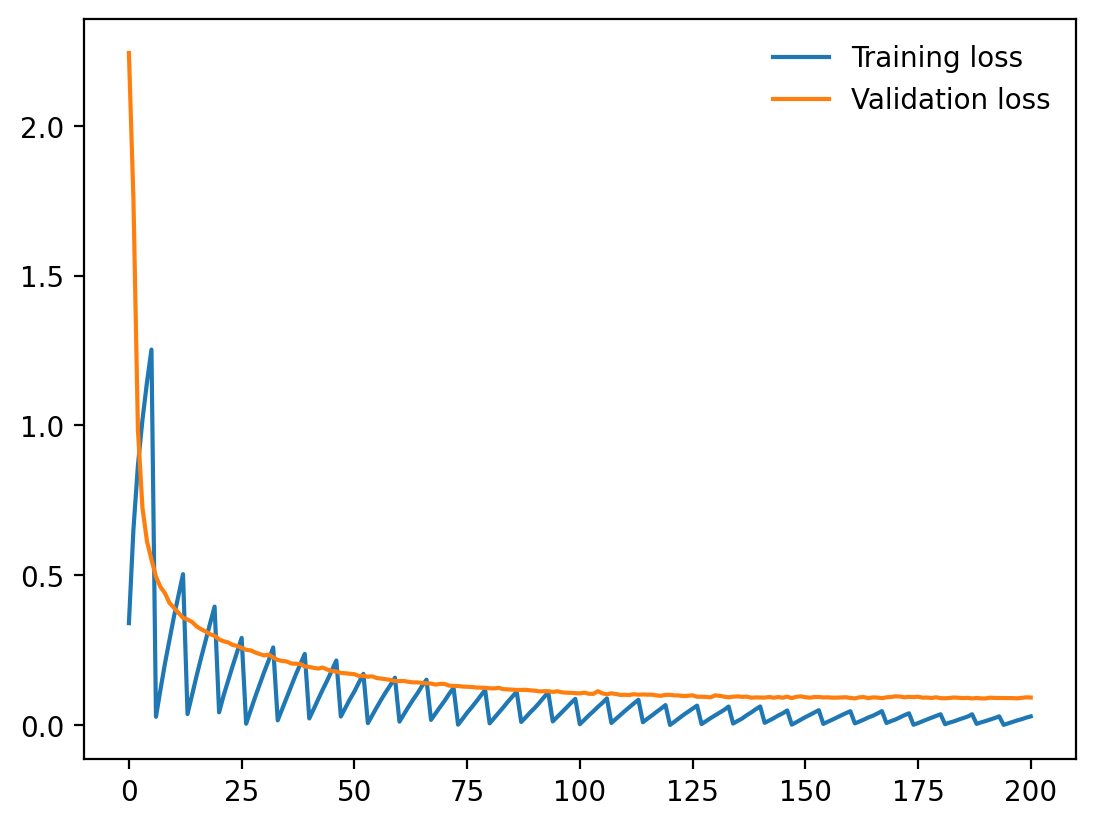

In [24]:
# Plot training and validation loss (visualize for tuning learning rate and epochs)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [25]:
#Save Final Model
state_dict = model.state_dict()
# torch.save(object, filename). For the filename, any extension can be used
torch.save(state_dict, "mnist_model.tar")

In [30]:
#Prepare validation set to predict labels for submissions 
validation = pd.read_csv("test.csv",dtype = np.float32)
#normalize validation values
validation_numpy = validation.values/255 # normalization
# data loader
validation_loader = DataLoader(validation_numpy, batch_size = batch_size, shuffle = False)


In [31]:
# Genetare predictions on validation set for submission
final_predictions = torch.tensor([]).long()
for images in validation_loader: 
    test = Variable(images.view(-1, 28*28))
    
    # Forward propagation
    outputs = model(test) #Use your model here 
    
    # Get predictions from the maximum value
    predicted = torch.max(outputs.data, 1)[1] #max returns the probabilities and the index of the max in each list, [1] prints the index
    final_predictions = torch.cat((final_predictions, predicted), dim=0)

image_ids = list(range(1, len(final_predictions) + 1))

# create a DataFrame with the ImageID and Label columns
submission_df = pd.DataFrame({'ImageID': image_ids, 'Label': final_predictions.numpy()})

# save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

Challenges faced:
- I've previously used tensorflow and the little changes between tensorflow and pytorch were challenging
- It took me a second to figure out that we didn't have to use the starter code exactly - I was very confused for a while why we weren't splitting the training set into train/test portions


Public Leaderboard Score: 0.96839